In [12]:
"""
# 2230705 PoC by Marcus Fallqvist
Goal: Compare total dog veterinary and insurace costs with investing money to find a sweetspot where less money is paid but with individual gain.

- Estimates the total veterinary costs of having a dog with insurance, currently only data used with Jack Russel Terrier with Agria Hundförsäkring
- Calculates how much is needed to invest to reach a net 0 or positive outcome

ToDo:
- Build a model based on dog breed, age, insurance company 
- Extend investment policies
- Incorporate accidents and big surgeries (risk factor)
- Use clearer names and visuals
- Handle payout periods less than a year
"""
# Lets go! Imports
import pandas as pd
print(pd.__version__)
import numpy as np
import piplite
await piplite.install('seaborn')
import seaborn as sns

1.5.3


In [13]:
# Class Dog, default my best friend Fido:
class Dog:
    def __init__(self, name="Fido", life_expectancy=[13, 16], breed="Jack Russel Terrier", age=1, location="Sweden"):
        self.name = name
        self.life_expectancy = life_expectancy # span of min, max
        self.breed = breed
        self.age = age # Age of dog when buying insurance
        #self.location = location
        print("Dog Class loaded")

    # ToDo: Model life_expectancy from breed (Not MVP)
    # ToDo: Model genetic diseases, known issues


In [14]:
# Insurance Class
# Which also calculates min, max costs
class Insurance:
    def __init__(self, dog, name="Agria", monthly_premium=[141, 764], veterinary_average_spending=[3000, 16000], deductible=[1500, 3400], coverage=[0.75, 0.85], max_coverage=[30000, 160000], risk=[0.14, 0.28]):
        self.dog = dog
        self.name = name
        self.premium = [12*x for x in monthly_premium] # yearly=12*monthly
        self.veterinary_average_spending = veterinary_average_spending   # Could not find Sweden-> [min=Finland max=US]
        self.deductible = deductible # per year
        self.coverage = coverage # coverage from insurance company of vet costs 
        self.max_coverage = max_coverage # per insurance period, usually yearly in SEK
        #self.risk = risk # risk of an accident or bigger surgery per year
        # ToDo: Get data and implement more insurance companies
        # ToDo: Incorporate risk factor as accidents or surgeries
        print("Insurance Class loaded")
        
    """
    # ToDo: Increase price depending on breed and age
    breed_factor = {
        'breed1': 1.0,
        'breed2': 1.5,
        'breed3': 2.0,  # and so on
    }

    age_factor = {
        '1': 1.0,
        '2': 1.2,
        '3': 0.8,  # and so on
    }
    """
    def calculate_cost(self):
        # Vet costs per year
        self.years_list = range(1, 1+max(self.dog.life_expectancy))
        self.vet_min_list = [-x*min(self.veterinary_average_spending) for x in self.years_list]
        self.vet_max_list = [-x*max(self.veterinary_average_spending) for x in self.years_list]

        # Raw costs of vet+insurance per year
        costs_yearly = np.add(self.premium, self.veterinary_average_spending)
        self.vet_ins_min_list = [-x*min(costs_yearly) for x in self.years_list]
        self.vet_ins_max_list = [-x*max(costs_yearly) for x in self.years_list]

        # Calculate max payout to customer from insurance company (payout period assumed to be a year)
        insurance_payout_yearly = self.coverage * (np.subtract(self.veterinary_average_spending, self.deductible))
        self.insurance_payout_min_list = [x*min(insurance_payout_yearly) for x in self.years_list]
        self.insurance_payout_max_list = [x*max(insurance_payout_yearly) for x in self.years_list]

        # Effective yearly spending 
        self.spending_yearly = np.subtract(insurance_payout_yearly, costs_yearly)
        
        # Effective Life time spending 
        self.min_cost_list = [x*min(self.spending_yearly) for x in self.years_list]
        self.max_cost_list = [x*max(self.spending_yearly) for x in self.years_list]
        
        
    def generate_data(self, start_capital = 0, interest_rate = 0.08, yearly_investment = 0):
        # Generate insurance costs to be put in data frame
        self.calculate_cost()
        
        # ToDo: Lift investment class out of insurance
        # Calculate investment based on insurance
        my_investment = Investment(start_capital, interest_rate, yearly_investment)
        
        # Deduct the spending from saving
        min_capital, max_capital = my_investment.calculate_interest(self.spending_yearly, self.years_list)
        
        # Format data
        data = {"Years": self.years_list,
                "Vet_min": self.vet_min_list,
                "Vet_max": self.vet_max_list,
                "Vet_insurance_min": self.vet_ins_min_list,
                "Vet_insurance_max": self.vet_ins_max_list,
                "Insurance_payout_min": self.insurance_payout_min_list,
                "Insurance_payout_max": self.insurance_payout_max_list,
                "Insurance_min": self.min_cost_list, 
                "Insurance_max": self.max_cost_list,
                "Spending_Investing_min": min_capital,
                "Spending_Investing_max": max_capital
               }

        # Create pandas DataFrame
        df = pd.DataFrame(data)
        return df



In [15]:
# Investment model Class
class Investment:
    def __init__(self, start_capital, interest_rate, yearly_investment):
        if not isinstance(start_capital, (int, float)):
            raise ValueError("start_capital must be a numeric value.")
        if not isinstance(interest_rate, float):
            raise ValueError("interest_rate must be a floating-point value.")
        if interest_rate <= 0 or interest_rate > 1:
            raise ValueError("interest_rate must be between 0 and 1.")
        if not isinstance(yearly_investment, (int, float)):
            raise ValueError("yearly_investment must be a numeric value.")
        if yearly_investment < 0:
            raise ValueError("yearly_investment must be positive.")
        self.interest_rate = interest_rate
        self.start_capital = start_capital
        self.yearly_investment = yearly_investment
        print("Interest Class loaded")

    # Calculate yearly return based on start capital, yearly investment, interest years and number of years
    def calculate_yearly_return(self, costs_yearly, num_years):
        total_amount = self.start_capital * (1 + self.interest_rate)**num_years
        if (self.yearly_investment + costs_yearly < 0):
            total_amount += self.yearly_investment + costs_yearly*num_years
        else:
            total_amount += (self.yearly_investment + costs_yearly) * (((1 + self.interest_rate)**num_years) - 1) / self.interest_rate
        return total_amount

    # Create list with calculated values per year by set interest
    def calculate_interest(self, costs_yearly, years_list):    
        min_capital = [self.calculate_yearly_return(min(costs_yearly), x) for x in years_list]
        max_capital = [self.calculate_yearly_return(max(costs_yearly), x) for x in years_list]
        return min_capital, max_capital
    


In [16]:
# Model costs per year from data
# Initialist dog class
my_dog = Dog('Fido')
# Then, insurance
my_insurance = Insurance(my_dog)
# Now, generate data insurance vs investing
df = my_insurance.generate_data()

# Visualise data in text
#print("df.head()\n {}\n".format(df.head()))

Dog Class loaded
Insurance Class loaded
Interest Class loaded


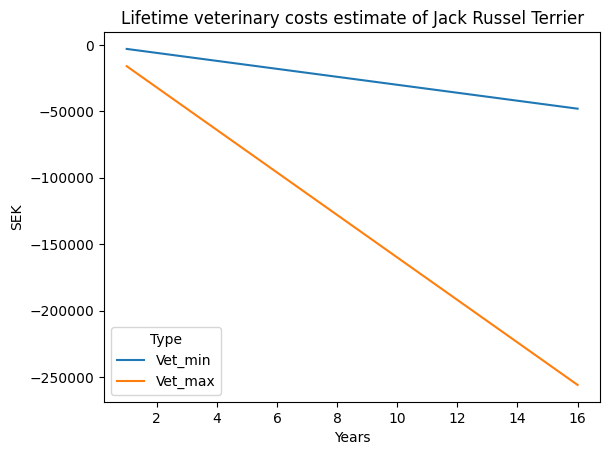

In [17]:
# Reformat data and visualise in graph
def visualise(input_df, strings = [""], title_string='input title'):
    # Input data
    #print("input_df.head() \n{}\n".format(input_df.head()))

    # Build a list of relevant strings, Years is always needed
    s_list = ["Years"]
    for s in strings:
        s_list.append(s)
    # Temporarily get the relevant data     
    temp = input_df[s_list]
    # Reconstruct in the way we want 
    output = temp.melt(id_vars='Years',
                   var_name='Type',
                   value_name='SEK')

    # Print and plot data
    #print("output.head() \n{}\n".format(output.head()))
    sns.lineplot(data=output, x="Years", y="SEK", hue="Type").set(title=title_string)
 
# First show just the Lifetime veterinary costs estimate 
input_string=['Vet_min','Vet_max']
visualise(df, input_string, 'Lifetime veterinary costs estimate of {}'.format(my_dog.breed))

In [18]:
# Visualise lifetime vet costs+insurance costs
input_string=['Vet_min','Vet_max', 'Vet_insurance_min', 'Vet_insurance_max']
#visualise(df, input_string,'Lifetime vet costs and veterinary+insurance costs {}'.format(my_dog.breed))

In [19]:
# Visualise vet costs+insurance and payout
input_string=['Vet_insurance_min', 'Vet_insurance_max', 'Insurance_payout_min', 'Insurance_payout_max']
#visualise(df, input_string,'Veterinary+insurance costs and insurane payout estimate of {}'.format(my_dog.breed))

In [20]:
def clean_data(input_data, columns_string):
    output_data = input_data[columns_string]
    return output_data
    
# Get data of insurance costs with added payout
vet_insurance = clean_data(df, ['Years', 'Vet_insurance_min', 'Vet_insurance_max'])

def add_to_data(input_data, extra_data):
    years = vet_insurance['Years'].unique()
    # Calculate total costs after insurance payout
    total_min = df['Vet_insurance_min'] + df['Insurance_payout_min']
    total_max = df['Vet_insurance_max'] + df['Insurance_payout_max']

    # Create a new dataframe for visualization
    vet_total_max = pd.DataFrame({'Years': years, 'Total_max': total_max})
    vet_total_min = pd.DataFrame({'Years': years, 'Total_min': total_min})

    # Combine the dataframes
    output = pd.concat([vet_insurance, vet_total_min, vet_total_max])
    return output

# Get relevant data
vet_combined = add_to_data(df, vet_insurance)

# Visualise vet costs+insurance and total (costs+insurance+payout)
input_string=['Vet_insurance_min', 'Vet_insurance_max', 'Total_min', 'Total_max']
#visualise(vet_combined, input_string, 'Vet+insurancy costs and total {}'.format(my_dog.breed))


Interest Class loaded


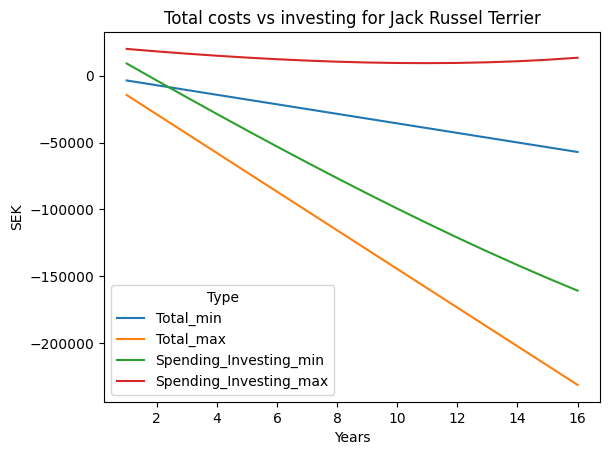

In [21]:
# Visualise total cost let us say we want to have some initial investment
# Change start_capital and interest_rate to find the sweetspot
# With min costs -> investing max: e.g. start_capital=20000, interest_rate=0.05, yearly_investment=2000
# With max costs -> investing min: e.g. start_capital=0, interest_rate=0.05, yearly_investment=15000
investing_df = my_insurance.generate_data(start_capital=20000, interest_rate=0.08, yearly_investment=2000)

# Get data of insurance costs with added payout
vet_insurance = clean_data(investing_df, ['Years', 'Vet_insurance_min', 'Vet_insurance_max','Spending_Investing_min', 'Spending_Investing_max'])

# Get relevant data
investing_data = add_to_data(df, vet_insurance)

# Visualise vet costs+insurance and investing
input_string=['Total_min', 'Total_max', 'Spending_Investing_min', 'Spending_Investing_max']

visualise(investing_data, input_string, 'Total costs vs investing for {}'.format(my_dog.breed))
